In [1]:
api_key = '08LTQ7UV6OYHKN5S' # alpha-vantage

In [2]:
ticker = "BTC-USD"

In [3]:
import yfinance as yf
import pandas as pd

def get_stock_data(stock_name, start_date, end_date, interval='1d'):
    try:
        df = yf.download(stock_name, start=start_date, end=end_date, interval=interval)
        return df
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [4]:
stock_data = get_stock_data(ticker, "2025-03-11", "2025-03-15", '1m')

[*********************100%***********************]  1 of 1 completed

YF.download() has changed argument auto_adjust default to True


In [5]:
row_counts = stock_data.resample("D").size()
row_counts

,0
Datetime,
2025-03-11 00:00:00+00:00,1130
2025-03-12 00:00:00+00:00,1126
2025-03-13 00:00:00+00:00,1107
2025-03-14 00:00:00+00:00,1109


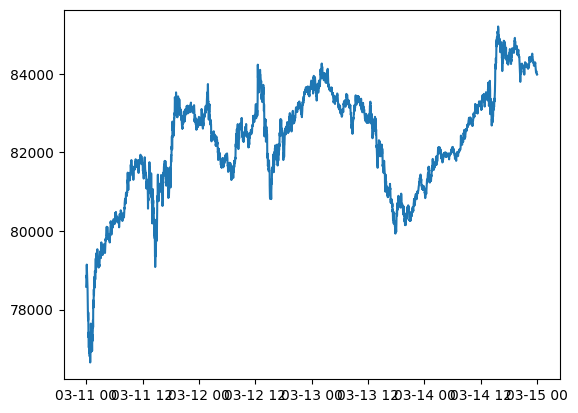

In [6]:
import matplotlib.pyplot as plt

plt.plot(stock_data['Close'])

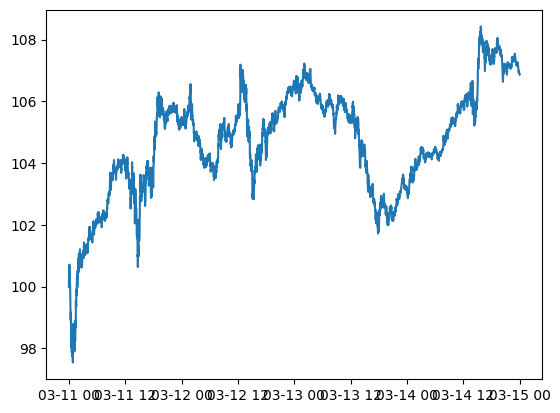

In [7]:
plt.plot(stock_data['Close'] / stock_data['Close'].iloc[0] * 100)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

In [9]:
stock_data.columns

MultiIndex([( 'Close', 'BTC-USD'),
            (  'High', 'BTC-USD'),
            (   'Low', 'BTC-USD'),
            (  'Open', 'BTC-USD'),
            ('Volume', 'BTC-USD')],
           names=['Price', 'Ticker'])

In [10]:
stock_data.columns = ['_'.join(col) for col in stock_data.columns]
stock_pcts = stock_data.pct_change()
stock_pcts_res = stock_pcts.iloc[1:]
stock_pcts_res = stock_pcts_res[f'Open_{ticker}']
means, stds = stock_pcts_res.mean(), stock_pcts_res.std()
stock_pcts_res_norm = (stock_pcts_res - means) / stds

In [11]:
class BaselineRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.2, breed='GRU'):
        super(BaselineRNN, self).__init__()
        self.rnn = nn.GRU(input_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True) if breed == 'GRU' else nn.LSTM(input_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.act = nn.SiLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

        self.apply(self.init_weights)

    def init_weights(self, module):
        if isinstance(module, nn.GRU) or isinstance(module, nn.LSTM):
            for name, param in module.named_parameters():
                if "weight_ih" in name:  # Input-hidden weights
                    nn.init.xavier_uniform_(param)
                elif "weight_hh" in name:  # Hidden-hidden weights
                    nn.init.orthogonal_(param)
                elif "bias" in name:  # Bias terms
                    nn.init.zeros_(param)
        elif isinstance(module, nn.Linear):
            nn.init.kaiming_uniform_(module.weight, nonlinearity='linear')
            if module.bias is not None:
                nn.init.zeros_(module.bias)

    def forward(self, x):
        # x shape: (seq_len, batch_size, input_size)
        out, h_n = self.rnn(x)  # out.shape = (batch_size, seq_len, hidden_size)
        out = self.fc1(out) # out.shape = (batch_size, seq_len, hidden_size)
        out = self.fc2(self.act(out))  # out.shape = (batch_size, seq_len, output_size)
        return out

In [12]:
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from tqdm import trange, tqdm

class MyDataset(Dataset):
    def __init__(self, data, seq_len, device='cpu'):
        self.data = data
        self.seq_len = seq_len
        self.device = device

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        idx = idx % len(self)
        X = self.data[idx: idx + self.seq_len]
        y= self.data[idx + 1: idx + self.seq_len + 1]
        return torch.tensor(X, dtype=torch.float32, device=self.device), torch.tensor(y, dtype=torch.float32, device=self.device)

In [28]:
SEQ_LEN = 700
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 256
PARTITION = 0.8

val_idx, actual_val_pred_idx = 1000, 300
data = stock_pcts_res_norm[:-val_idx].values.reshape(-1, 1)

In [29]:
dataset = MyDataset(data, SEQ_LEN, DEVICE)

len(dataset)

train_size, test_size = int(len(dataset) * PARTITION), len(dataset) - int(len(dataset) * PARTITION)
training_data, testing_data = random_split(dataset, [train_size, test_size])

print(len(training_data))

train_loader = DataLoader(training_data, batch_size=BATCH_SIZE)
test_loader = DataLoader(testing_data, batch_size=BATCH_SIZE)

NUM_LAYERS = 2
HID_DIM = 64
DROPOUT = 0.5
LR = 1e-4
NB_EPOCHS = 200
COEF = 0.5

2216


In [30]:
def train(input_size, hidden_size, output_size, num_layers, dropout, breed):
    input_size = data.shape[1]
    hidden_size = HID_DIM
    output_size = data.shape[1]
    num_layers = NUM_LAYERS
    dropout = DROPOUT

    model = BaselineRNN(input_size, hidden_size, output_size, num_layers, dropout, breed).to(DEVICE)

    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters())

    best_val_loss = float('inf')

    pbar = tqdm(range(NB_EPOCHS), desc="Epochs", unit="epoch", leave=True)
    for epoch in pbar:
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

            running_loss = running_loss * (1 - COEF) + loss.item() * COEF

        test_loss = 0.0
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                output = model(X_batch)
                test_loss = test_loss * (1 - COEF) + criterion(output, y_batch).item() * COEF

        pbar.set_postfix({'Train Loss': f'{running_loss:.4f}', 'Val Loss': f'{test_loss:.4f}'})
        # Checkpoint if validation loss improves
        if test_loss < best_val_loss:
            best_val_loss = test_loss
            torch.save(model.state_dict(), f'best_model_{breed}.pth')

In [31]:
for breed in ['GRU', 'LSTM']:
    train(data.shape[1], HID_DIM, data.shape[1], NUM_LAYERS, DROPOUT, breed)

Epochs: 100%|██████████| 200/200 [01:34<00:00,  2.11epoch/s, Train Loss=0.1038, Val Loss=0.0627]


In [32]:
stock_pcts_res[-val_idx:]

,Open_BTC-USD
Datetime,
2025-03-14 02:23:00+00:00,-0.000392
2025-03-14 02:25:00+00:00,0.000720
2025-03-14 02:26:00+00:00,-0.000081
2025-03-14 02:27:00+00:00,0.000370
2025-03-14 02:28:00+00:00,0.000285
...,...
2025-03-14 23:52:00+00:00,-0.000102
2025-03-14 23:54:00+00:00,-0.000139
2025-03-14 23:55:00+00:00,-0.000126


In [33]:
stock_pcts_res_norm[-val_idx:].shape

(1000,)

In [48]:
result_df = stock_pcts_res[-val_idx:].copy().to_frame()
result_df = result_df.iloc[SEQ_LEN:]

for breed in ['GRU', 'LSTM']:
    model = BaselineRNN(data.shape[1], HID_DIM, data.shape[1], NUM_LAYERS, DROPOUT, breed).to(DEVICE)
    model.load_state_dict(torch.load(f'best_model_{breed}.pth'))
    model.eval()

    df_subset = stock_pcts_res_norm[-val_idx:].copy().to_frame()

    def create_sequences(df):
        X = []
        for i in range(len(df) - SEQ_LEN + 1):
            X.append(torch.tensor((df.iloc[i:i + SEQ_LEN]).values, dtype=torch.float32, device=DEVICE))
        return torch.stack(X, dim=0)

    X = create_sequences(df_subset)
    predictions = model(X.clone().detach())[:-1]  # Shape: (n_samples, seq_len, n_features)

    last_step_predictions = predictions[:, -1, :]  * torch.tensor(np.array(stds).reshape(1, -1), device=DEVICE) + torch.tensor(np.array(means).reshape(1, -1), device=DEVICE)

    pred_columns = [f'{breed}_Pred_{col.split("_")[0]}_{ticker}' for col in df_subset.columns]
    pred_df = pd.DataFrame(last_step_predictions.detach().cpu().numpy(), index=df_subset.index[SEQ_LEN:], columns=pred_columns)

    for col in pred_df.columns:
        result_df[col] = pred_df[col]

In [49]:
result_df.copy()[-100:]

,Open_BTC-USD,GRU_Pred_Open_BTC-USD,LSTM_Pred_Open_BTC-USD
Datetime,,,
2025-03-14 21:53:00+00:00,0.000212,0.000247,-0.000591
2025-03-14 21:54:00+00:00,0.000056,0.000203,-0.001020
2025-03-14 21:55:00+00:00,-0.000466,0.000131,-0.001129
2025-03-14 21:57:00+00:00,-0.000191,0.000006,-0.000753
2025-03-14 21:58:00+00:00,-0.000063,-0.000098,-0.000094
...,...,...,...
2025-03-14 23:52:00+00:00,-0.000102,0.000186,-0.000137
2025-03-14 23:54:00+00:00,-0.000139,-0.000192,-0.000486
2025-03-14 23:55:00+00:00,-0.000126,0.000087,-0.000998


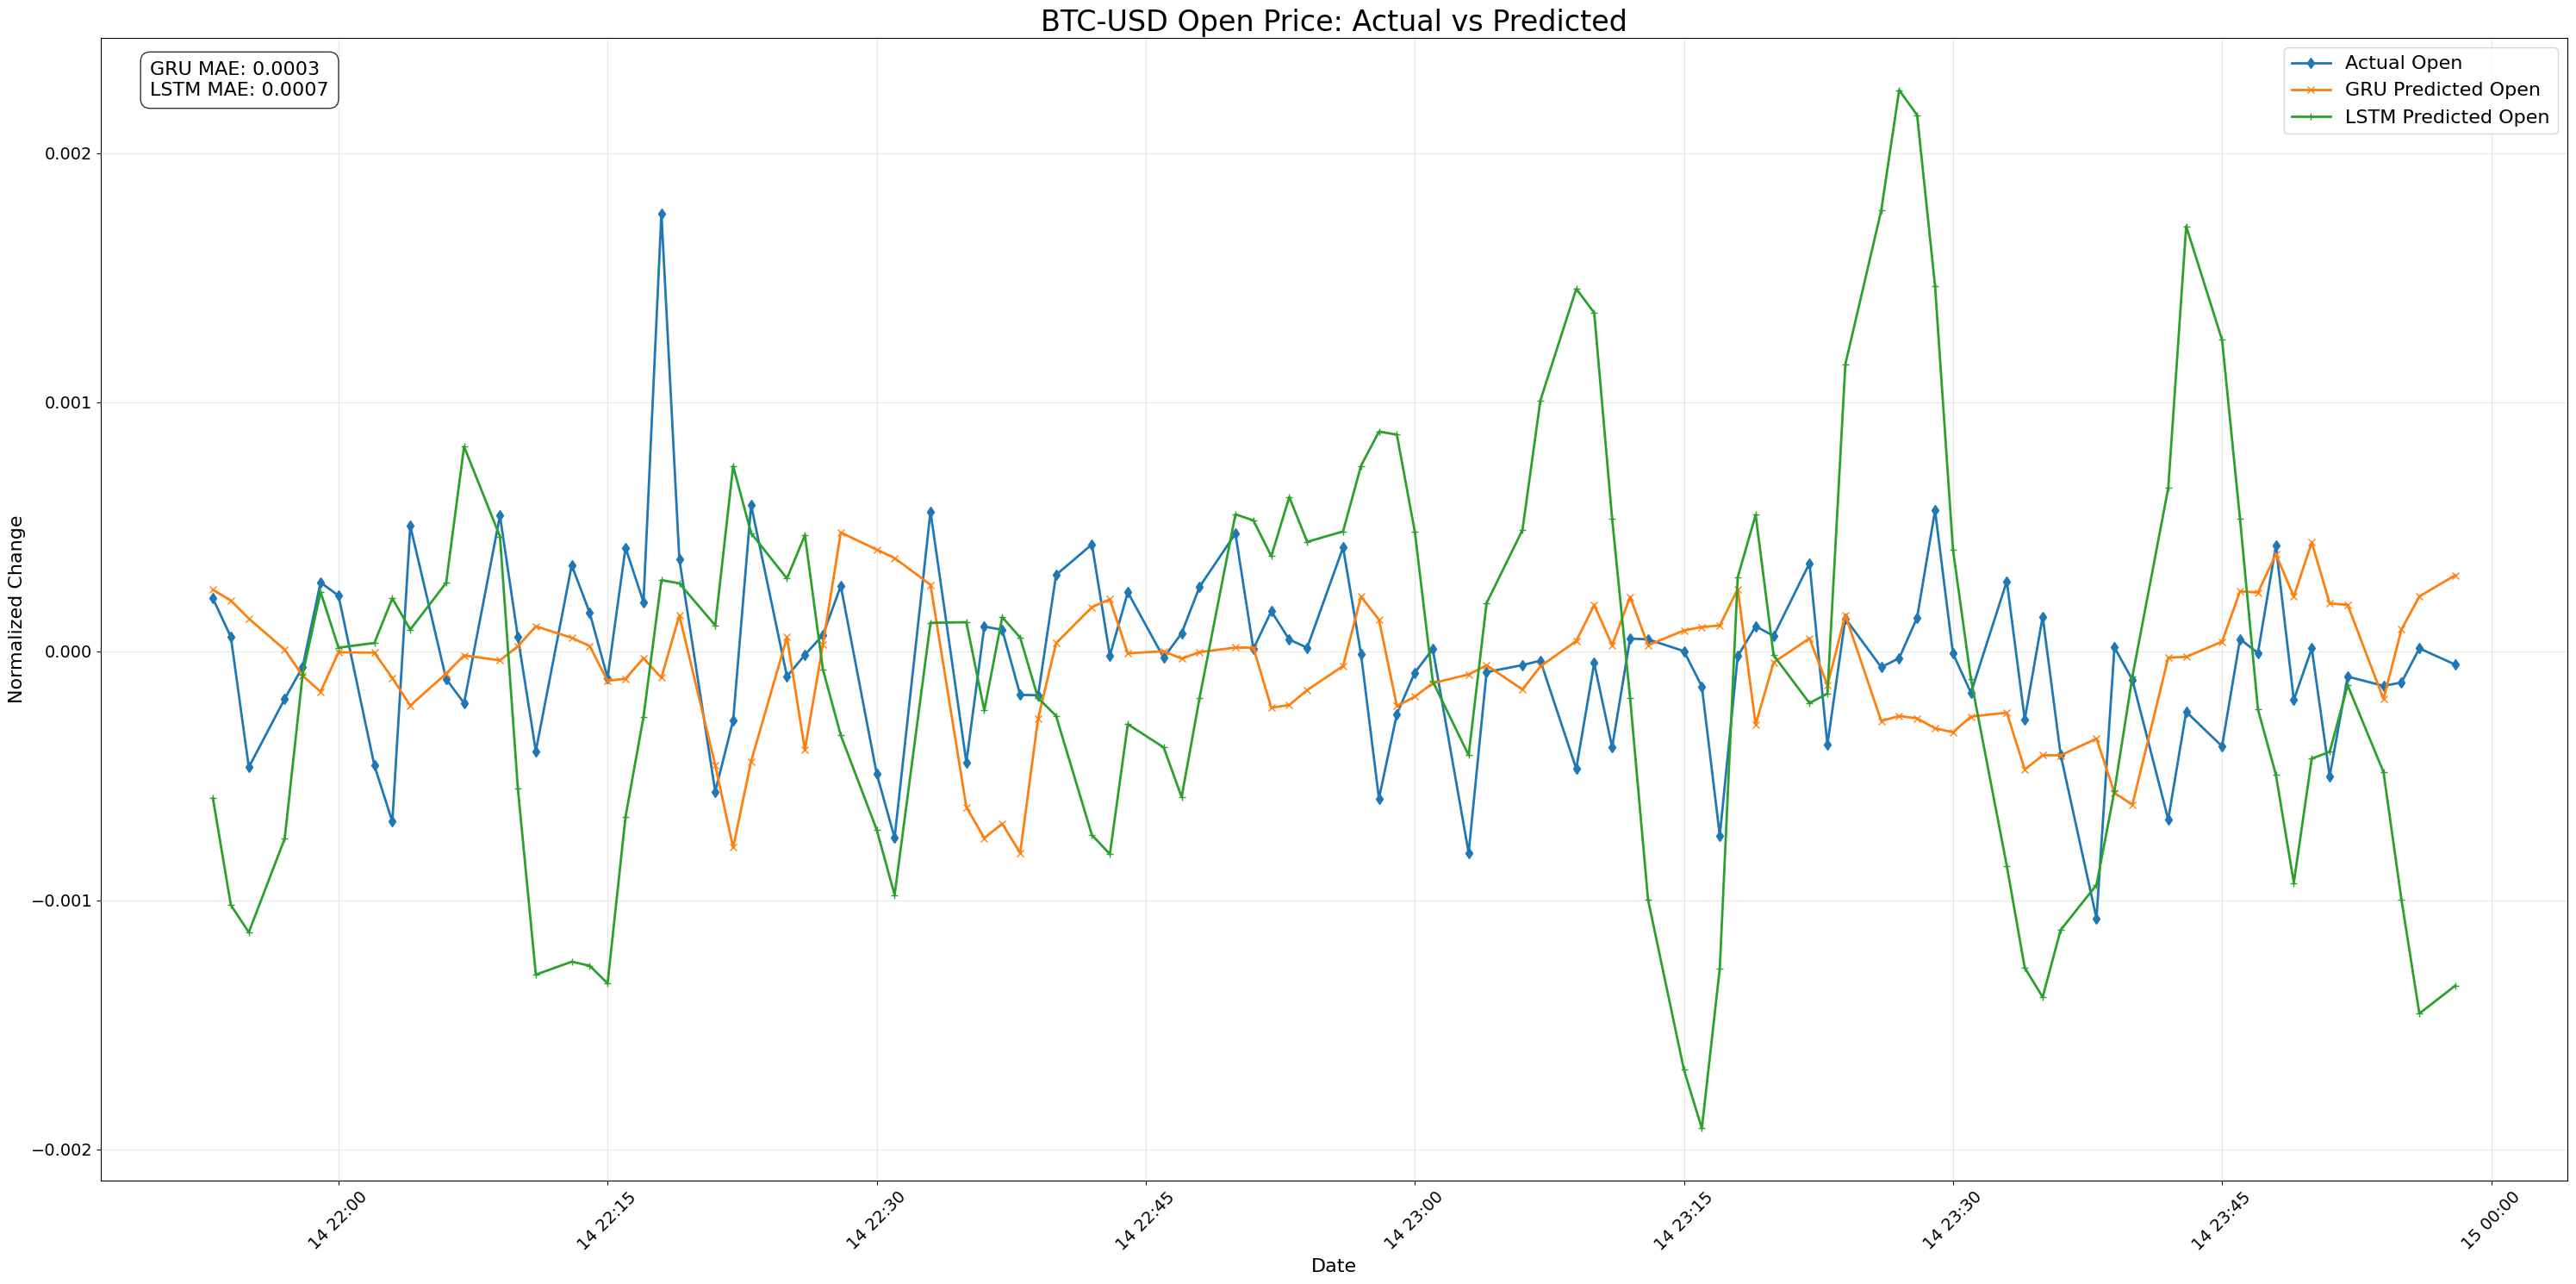

In [50]:
df_pred = result_df.copy()[-100:]
timeline = df_pred.index

# Create a single large figure
plt.figure(figsize=(30, 15))

# Create the Open price plot
plt.plot(timeline, df_pred[f'Open_{ticker}'], label='Actual Open', marker='d', linewidth=2)
plt.plot(timeline, df_pred[f'GRU_Pred_Open_{ticker}'], label='GRU Predicted Open', marker='x', linewidth=2)
plt.plot(timeline, df_pred[f'LSTM_Pred_Open_{ticker}'], label='LSTM Predicted Open', marker='+', linewidth=2)

# Add labels and formatting
plt.xlabel('Date', fontsize=16)
plt.ylabel('Normalized Change', fontsize=16)
plt.title(f'{ticker} Open Price: Actual vs Predicted', fontsize=24)
plt.legend(fontsize=16)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)

# Calculate metrics for annotation
gru_mae = np.mean(np.abs(df_pred[f'Open_{ticker}'] - df_pred[f'GRU_Pred_Open_{ticker}']))
lstm_mae = np.mean(np.abs(df_pred[f'Open_{ticker}'] - df_pred[f'LSTM_Pred_Open_{ticker}']))

# Add metrics as text annotation
plt.annotate(f'GRU MAE: {gru_mae:.4f}\nLSTM MAE: {lstm_mae:.4f}',
             xy=(0.02, 0.95), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8),
             fontsize=16)

plt.tight_layout()
plt.show()